In [2]:
import re
import pandas as pd
from pathlib import Path
import spacy

nlp = spacy.load("en_core_web_sm")
nlp.max_length = 2000000

In [2]:
# Cleaning first part of text obtained from project guttenberg
def clean_guttenberg_header(text):
  ex = r"The Project Gutenberg eBook.*?\*\*\* START OF THE PROJECT GUTENBERG EBOOK.*?\*\*\*"
  main_text = re.sub(ex, "", text, flags=re.DOTALL)
  return main_text

# Cleaning out the footer extra info added by project gutteneberg
def clean_guttenberg_footer(text):
  ex = r"\*\*\* END OF THE PROJECT GUTENBERG EBOOK.*"
  main_text = re.sub(ex, "", text, flags=re.DOTALL)
  return main_text

def clean_guttenberg(text):
  clean = clean_guttenberg_header(text)
  clean = clean_guttenberg_footer(clean)
  return clean

In [3]:
data_dir = Path('./data')
 
corpus = {
    'Christie': [clean_guttenberg(p.read_text(encoding='utf-8-sig')) for p in (data_dir / 'ac').glob('*.txt')],
    'Chesterton':  [clean_guttenberg(p.read_text(encoding='utf-8-sig')) for p in (data_dir / 'gc').glob('*.txt')],
    'Melville':  [clean_guttenberg(p.read_text(encoding='utf-8-sig')) for p in (data_dir / 'hm').glob('*.txt')],
    'Leblanc':  [clean_guttenberg(p.read_text(encoding='utf-8-sig')) for p in (data_dir / 'ml').glob('*.txt')],
    'Doyle': [clean_guttenberg(p.read_text(encoding='utf-8-sig')) for p in (data_dir / 'cd').glob('*.txt')],
    'Carroll': [clean_guttenberg(p.read_text(encoding='utf-8-sig')) for p in (data_dir / 'lc').glob('*.txt')],
}

for author, works in corpus.items():
    print(f'{author}: {len(works)}')

Christie: 12
Chesterton: 26
Melville: 5
Leblanc: 17
Doyle: 43
Carroll: 4


In [4]:
def sentence_chunk(text, chunk_size=100, overlap=50):
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents if len(sent.text.strip()) > 1]
    chunks = []
    for i in range(0, len(sentences), chunk_size - overlap):
        chunk = ' '.join(sentences[i:i + chunk_size])
        chunks.append(chunk)
    return chunks

In [5]:
chunk_size = 100
overlap = 0
dataset = {}
for author, works in corpus.items():
    dataset[author] = []
    for text in works:
        dataset[author].extend(sentence_chunk(text, chunk_size = chunk_size, overlap=overlap))

# Print the number of chunks for each list
for author, texts in dataset.items():
    print(f'{author}: {len(texts)} chunks')

Christie: 517 chunks
Chesterton: 692 chunks
Melville: 278 chunks
Leblanc: 929 chunks
Doyle: 1469 chunks
Carroll: 58 chunks


In [6]:
def prepare_data(text):
  doc = nlp(text)
  normalized_tokens = []
  word_lengths= []
  sent_lengths= []

  for token in doc:
    if token.is_punct or token.is_space:
      continue
    token_text = token.text.strip().lower()
    normalized_tokens.append(token_text)
    word_lengths.append(len(token_text))
  normalized_text = ' '.join(normalized_tokens)

  sent_lengths=[len(sent) for sent in doc.sents]
  return normalized_text, word_lengths, sent_lengths

In [7]:
#Nomalize text, get word lengths and sentence lengths
wholeCorpus = ""
data_x = []
label_y = []
for author, works in dataset.items():
    for text in works:
        wholeCorpus += text
        normalized_text, word_lengths, sent_lengths = prepare_data(text)
        data_x.append(normalized_text)
        label_y.append(author)

#### Feature Engineering

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(stop_words='english')
bow_vectorizer.fit(data_x)

CountVectorizer(stop_words='english')

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_vectorizer.fit(data_x)

TfidfVectorizer(stop_words='english')

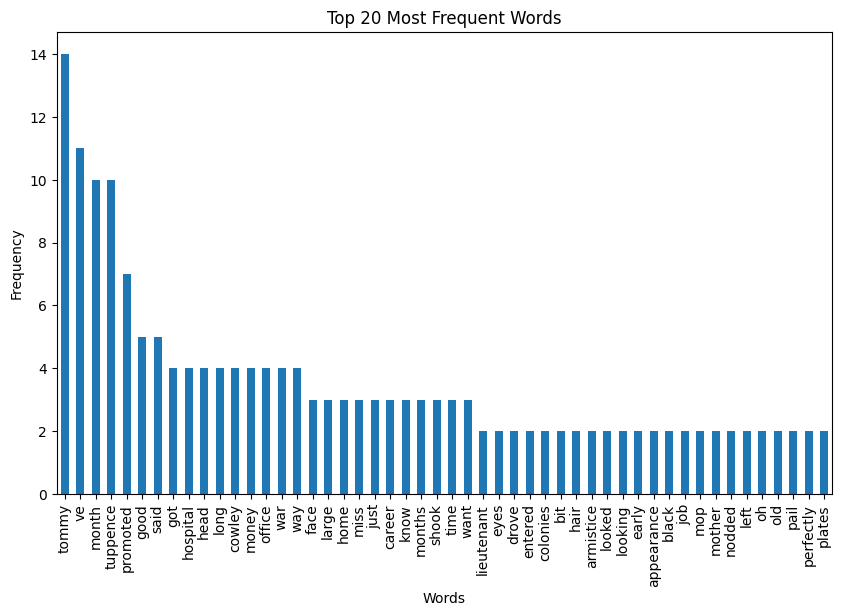

In [10]:
import matplotlib.pyplot as plt

bow_matrix = bow_vectorizer.transform([data_x[1]]) 
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=bow_vectorizer.get_feature_names_out())
bow_df.head()
word_counts = bow_df.sum(axis=0)
sorted_word_counts = word_counts.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sorted_word_counts.head(50).plot(kind='bar')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [11]:
from sklearn.preprocessing import OneHotEncoder
target_encoder = OneHotEncoder(sparse_output=False)
y = target_encoder.fit_transform(pd.DataFrame(label_y))

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

X = []

for item in data_x:
    X.append(bow_vectorizer.transform([item]).toarray().flatten())
     
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

              precision    recall  f1-score   support

     Carroll       1.00      0.85      0.92        20
  Chesterton       0.99      0.97      0.98       212
    Christie       1.00      0.95      0.98       174
       Doyle       1.00      0.98      0.99       424
     Leblanc       1.00      0.99      0.99       273
    Melville       0.99      0.96      0.97        80

   micro avg       1.00      0.97      0.98      1183
   macro avg       1.00      0.95      0.97      1183
weighted avg       1.00      0.97      0.98      1183
 samples avg       0.97      0.97      0.97      1183



c:\Users\amiri\Documents\GitHub\nlp-524\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


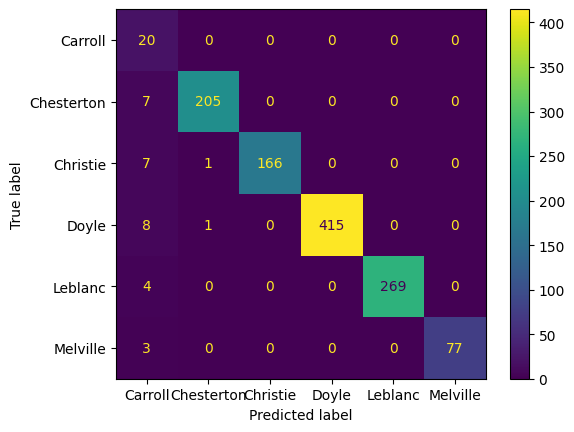

In [13]:
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred, target_names=target_encoder.categories_[0]))
ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1), pred.argmax(axis=1), display_labels=target_encoder.categories_[0])

              precision    recall  f1-score   support

     Carroll       1.00      0.85      0.92        20
  Chesterton       0.98      0.99      0.99       212
    Christie       1.00      0.98      0.99       174
       Doyle       0.98      1.00      0.99       424
     Leblanc       1.00      1.00      1.00       273
    Melville       0.99      0.97      0.98        80

    accuracy                           0.99      1183
   macro avg       0.99      0.96      0.98      1183
weighted avg       0.99      0.99      0.99      1183



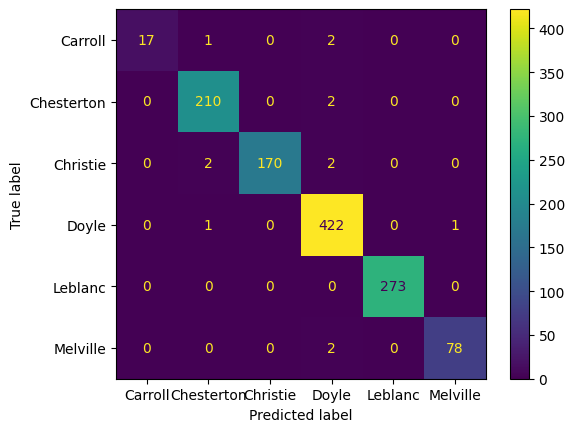

In [14]:
from sklearn.svm import SVC

svm_classifier = SVC(gamma='auto', kernel='linear')
svm_classifier.fit(X_train, y_train.argmax(axis=1))
pred = svm_classifier.predict(X_test)
print(classification_report(y_test.argmax(axis=1), pred, target_names=target_encoder.categories_[0]))
ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1), pred, display_labels= target_encoder.categories_[0]) 


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

X = []

for item in data_x:
    X.append(tfidf_vectorizer.transform([item]).toarray().flatten())
     
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

              precision    recall  f1-score   support

     Carroll       1.00      0.60      0.75        20
  Chesterton       1.00      0.98      0.99       212
    Christie       1.00      0.95      0.98       174
       Doyle       1.00      0.99      1.00       424
     Leblanc       1.00      1.00      1.00       273
    Melville       1.00      0.88      0.93        80

   micro avg       1.00      0.97      0.99      1183
   macro avg       1.00      0.90      0.94      1183
weighted avg       1.00      0.97      0.98      1183
 samples avg       0.97      0.97      0.97      1183



c:\Users\amiri\Documents\GitHub\nlp-524\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


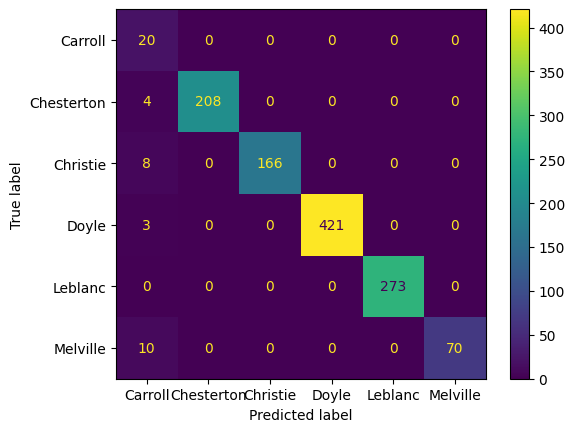

In [16]:
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred, target_names=target_encoder.categories_[0]))
ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1), pred.argmax(axis=1), display_labels= target_encoder.categories_[0])

              precision    recall  f1-score   support

     Carroll       1.00      0.65      0.79        20
  Chesterton       1.00      1.00      1.00       212
    Christie       1.00      0.99      1.00       174
       Doyle       0.98      1.00      0.99       424
     Leblanc       1.00      1.00      1.00       273
    Melville       1.00      0.99      0.99        80

    accuracy                           0.99      1183
   macro avg       1.00      0.94      0.96      1183
weighted avg       0.99      0.99      0.99      1183



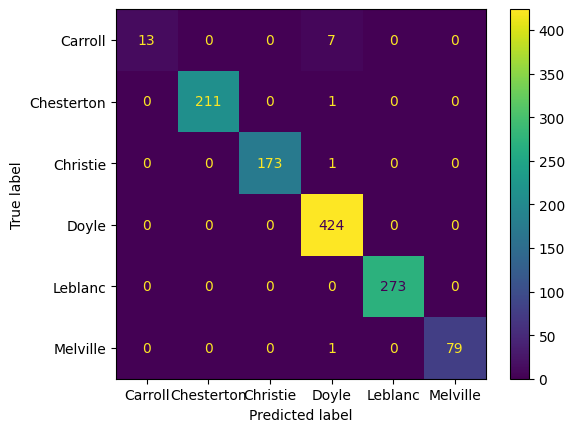

In [17]:
from sklearn.svm import SVC

svm_classifier = SVC(gamma='auto', kernel='linear')
svm_classifier.fit(X_train, y_train.argmax(axis=1))
pred = svm_classifier.predict(X_test)
print(classification_report(y_test.argmax(axis=1), pred, target_names=target_encoder.categories_[0]))
ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1), pred, display_labels= target_encoder.categories_[0]) 


### Unsupervised Approach Using Word Embeddings

In [18]:
import pickle

# Save the dataset object to a file
with open('dataset.pkl', 'wb') as file:
    pickle.dump(dataset, file)

In [3]:
import pickle

# Load the dataset object from the file
with open('dataset.pkl', 'rb') as file:
    dataset = pickle.load(file)

# Verify the loaded dataset
for author, texts in dataset.items():
    print(f'{author}: {len(texts)} chunks')

EOFError: Ran out of input

In [4]:
import spacy
nlp = spacy.load("en_core_web_md")

In [6]:
doc = nlp("This is a sentence.")
doc.vector.size

300

In [18]:
import numpy as np

vectors = []
authors = []

for author, chunks in dataset.items():
    for chunk in chunks:
        vectors.append(nlp(chunk).vector)
        authors.append(author)

vectors_array = np.array(vectors)
print(vectors_array.shape)

(3943, 300)


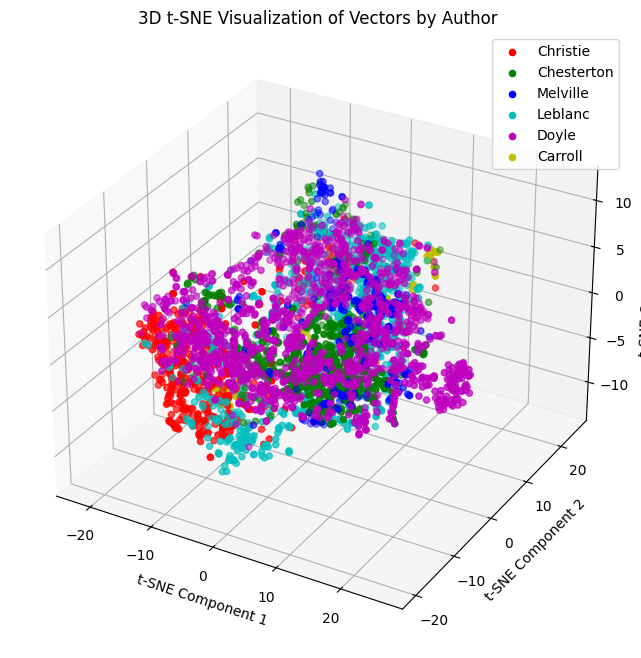

In [19]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

# Reduce dimensions using t-SNE
tsne_3d = TSNE(n_components=3, random_state=42)
vectors_tsne_3d = tsne_3d.fit_transform(vectors_array)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define colors for each author
colors = {'Christie': 'r', 'Chesterton': 'g', 'Melville': 'b', 'Leblanc': 'c', 'Doyle': 'm', 'Carroll': 'y'}

# Plot each author's vectors with a different color
for author in dataset.keys():
    indices = [i for i, a in enumerate(authors) if a == author]
    ax.scatter(vectors_tsne_3d[indices, 0], vectors_tsne_3d[indices, 1], vectors_tsne_3d[indices, 2], c=colors[author], label=author)

# Add labels and title
ax.set_title('3D t-SNE Visualization of Vectors by Author')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.legend()

plt.show()

In [15]:
from sklearn.cluster import KMeans

# Number of authors in the dataset
num_authors = len(dataset.keys())

# Perform KMeans clustering
kmeans = KMeans(n_clusters=num_authors, random_state=42)
kmeans.fit(vectors_array)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Print the cluster labels
print(cluster_labels)

[2 2 2 ... 5 5 5]


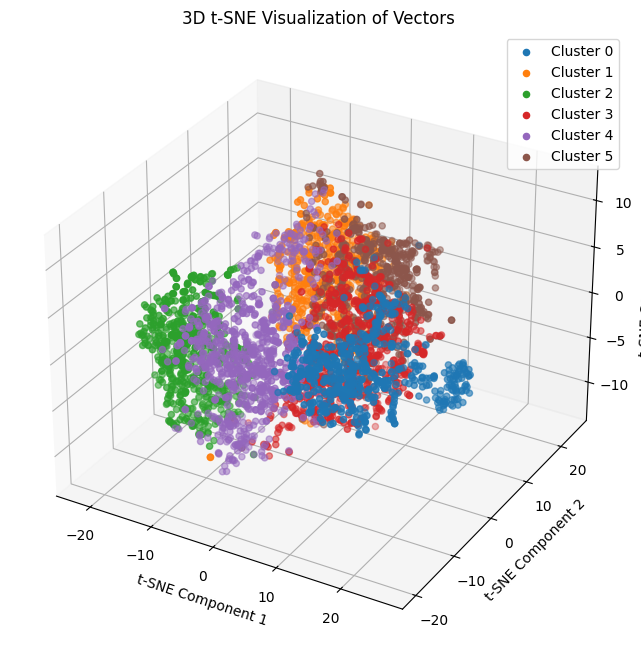

In [16]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

# Reduce dimensions using t-SNE
tsne_3d = TSNE(n_components=3, random_state=42)
vectors_tsne_3d = tsne_3d.fit_transform(vectors_array)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster with a different color
for cluster in range(num_authors):
    indices = cluster_labels == cluster
    ax.scatter(vectors_tsne_3d[indices, 0], vectors_tsne_3d[indices, 1], vectors_tsne_3d[indices, 2], label=f'Cluster {cluster}')

# Add labels and title
ax.set_title('3D t-SNE Visualization of Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.legend()

plt.show()